# Simulation - Varying Redstone L1 data fee parameters

#### Maria Silva, March 2024

## Load & imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
code_dir = os.path.realpath(os.path.join(os.getcwd(), ".."))

import sys
sys.path.append(code_dir)

In [3]:
from redsim.params import Params
from redsim.sim import run_mc_sim

## Set paramaters

In [4]:
sim_len = int(30 * 60 * 60 * 24 / 12)  # 30 day of ETH blocks
sim_iter = 1000  # MC paths

params = Params()
params.set_default_params()

l1_fee_overhead_list = [2100.0, 0.0]
l1_fee_scalar_list = [100000.0, 50000.0, 7000.0]

## Run full MC simulation

In [5]:
sim_df = pd.DataFrame()

for l1_fee_overhead in l1_fee_overhead_list:
    for l1_fee_scalar in l1_fee_scalar_list:
        # set paramters
        params.set_param("l1_fee_overhead", l1_fee_overhead)
        params.set_param("l1_fee_scalar", l1_fee_scalar)
        # run sim
        temp_df = run_mc_sim(sim_len, sim_iter, params, agg_daily = True)
        temp_df["l1_fee_overhead"] = l1_fee_overhead
        temp_df["l1_fee_scalar"] = l1_fee_scalar
        sim_df = pd.concat([sim_df, temp_df], ignore_index=True)
    
sim_df.to_csv("../data/sim_l1_fee_params_output.csv", index=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:37<00:00,  6.36it/s]


## Analyse results

In [4]:
sim_df = pd.read_csv("../data/sim_l1_fee_params_output.csv")
sim_df["l1_fee_overhead"] = sim_df["l1_fee_overhead"].astype("str")
sim_df["l1_fee_scalar"] = sim_df["l1_fee_scalar"].astype("str")
sim_df["scenario"] = "l1_fee_overhead: " + sim_df["l1_fee_overhead"] + "; l1_fee_scalar: " + sim_df["l1_fee_scalar"]
sim_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180000 entries, 0 to 179999
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   timestamp              180000 non-null  object 
 1   onchain_profit_eth     180000 non-null  float64
 2   onchain_profit_usd     180000 non-null  float64
 3   total_profit_eth       180000 non-null  float64
 4   total_profit_usd       180000 non-null  float64
 5   op_rev_share_cost_eth  180000 non-null  float64
 6   l1_base_fee_gwei       180000 non-null  float64
 7   l1_prio_fee_gwei       180000 non-null  float64
 8   l2_base_fee_gwei       180000 non-null  float64
 9   l2_prio_fee_gwei       180000 non-null  float64
 10  l2_gas                 180000 non-null  float64
 11  da_challenge           180000 non-null  float64
 12  infra_cost_usd         180000 non-null  float64
 13  revenue_eth            180000 non-null  float64
 14  revenue_data_eth       180000 non-nu

In [7]:
temp_df = (
    sim_df[sim_df["timestamp"]==sim_df["timestamp"].max()] # get last day of sim
    .groupby(["l1_fee_overhead", "l1_fee_scalar"])
    [["onchain_profit_eth", "total_profit_eth", "op_rev_share_cost_eth", "onchain_profit_usd", "total_profit_usd"]]
    .agg(["mean", "std"])
    .round(2)
)
temp_df

onchain_profit_eth       total_profit_eth        \
                                            mean   std             mean   std   
l1_fee_overhead l1_fee_scalar                                                   
0.0             100000.0                   76.98  0.50            61.37  0.42   
                50000.0                    28.74  0.24            20.37  0.20   
                7000.0                    -12.76  0.12           -17.04  0.12   
2100.0          100000.0                   78.20  0.50            62.41  0.43   
                50000.0                    29.34  0.24            20.88  0.20   
                7000.0                    -12.68  0.12           -16.96  0.12   

                              op_rev_share_cost_eth       onchain_profit_usd  \
                                               mean   std               mean   
l1_fee_overhead l1_fee_scalar                                                  
0.0             100000.0                      11.55  0.07          192456.83   
                50000.0                        4.31  0.04           71858.33   
                7000.0                         0.22  0.00          -31890.12   
2100.0          100000.0                      11.73  0.08          195496.29   
                50000.0                        4.40  0.04           73354.33   
                7000.0                         0.22  0.00          -31687.60   

                                       total_profit_usd           
                                   std             mean      std  
l1_fee_overhead l1_fee_scalar                                     
0.0             100000.0       1237.85        153436.27  1052.32  
                50000.0         601.77         50927.69   511.58  
                7000.0          309.35        -42588.29   309.53  
2100.0          100000.0       1259.70        156019.82  1070.87  
                50000.0         599.35         52199.23   509.63  
                7000.0          304.71        -42391.05   304.81

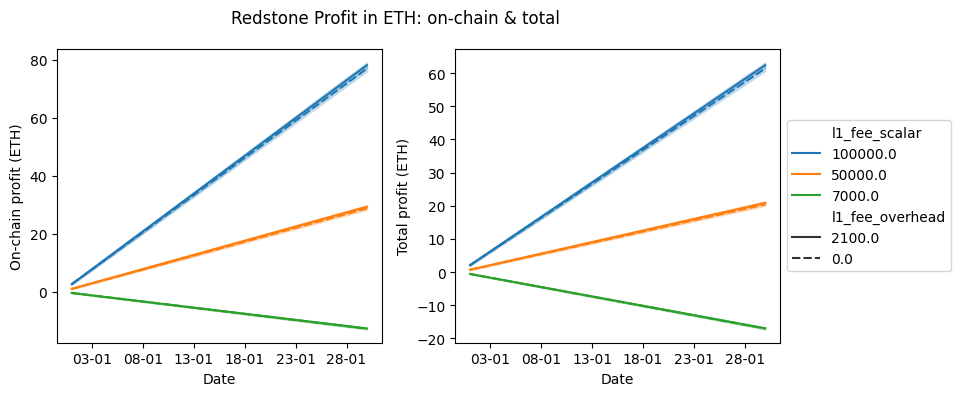

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=False)
sns.lineplot(data=sim_df, x="timestamp", y="onchain_profit_eth", hue="l1_fee_scalar", 
             style="l1_fee_overhead", errorbar="pi", ax=axs[0], legend=False)
axs[0].set_xlabel("Date") 
axs[0].set_ylabel("On-chain profit (ETH)") 
axs[0].xaxis.set_major_locator(mdates.DayLocator(interval=5))
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
sns.lineplot(data=sim_df, x="timestamp", y="total_profit_eth",hue="l1_fee_scalar", 
             style="l1_fee_overhead", errorbar="pi", ax=axs[1])
axs[1].set_xlabel("Date") 
axs[1].set_ylabel("Total profit (ETH)") 
plt.suptitle("Redstone Profit in ETH: on-chain & total")
axs[1].xaxis.set_major_locator(mdates.DayLocator(interval=5))
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.tight_layout()
axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

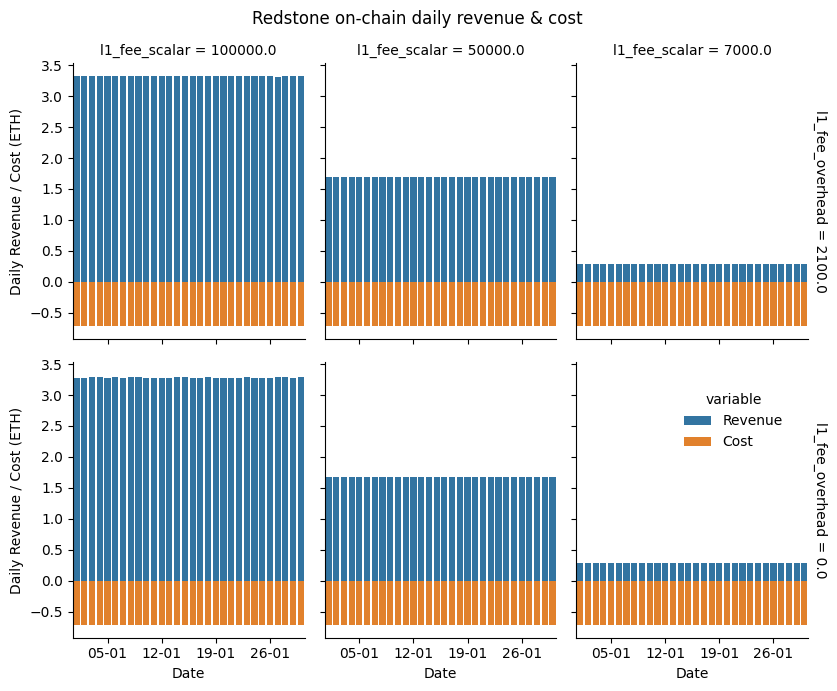

In [9]:
temp_df = sim_df.copy()
temp_df["Revenue"] = temp_df["revenue_eth"]
temp_df["Cost"] = -temp_df["onchain_cost_eth"]
temp_df = temp_df.melt(id_vars=["timestamp", "l1_fee_scalar", "l1_fee_overhead"], value_vars=["Revenue", "Cost"])

g = sns.catplot(data=temp_df, x="timestamp", y="value", hue="variable", col="l1_fee_scalar", row="l1_fee_overhead",
                kind="bar", height=3.5, aspect=0.7, estimator="mean", errorbar=None, dodge=False, margin_titles=True)
g.set(xlabel="Date", ylabel="Daily Revenue / Cost (ETH)")
for ax in g.axes[0]:
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.suptitle("Redstone on-chain daily revenue & cost")
plt.tight_layout()
sns.move_legend(g, "upper left", bbox_to_anchor=(0.8, 0.45))
plt.show()

In [10]:
temp_df = (
    sim_df
    .groupby(["l1_fee_overhead", "l1_fee_scalar"])
    [["revenue_data_eth", "revenue_exec_eth", "batcher_gas_cost_eth", "proposer_gas_cost_eth", "da_gas_cost_eth"]]
    .agg(["mean", "std"])
    .round(3)
)
temp_df

revenue_data_eth        revenue_exec_eth         \
                                          mean    std             mean    std   
l1_fee_overhead l1_fee_scalar                                                   
0.0             100000.0                 3.217  0.096            0.066  0.003   
                50000.0                  1.608  0.048            0.066  0.003   
                7000.0                   0.225  0.007            0.066  0.003   
2100.0          100000.0                 3.257  0.095            0.066  0.003   
                50000.0                  1.628  0.048            0.066  0.003   
                7000.0                   0.228  0.007            0.066  0.003   

                              batcher_gas_cost_eth         \
                                              mean    std   
l1_fee_overhead l1_fee_scalar                               
0.0             100000.0                     0.645  0.014   
                50000.0                      0.644  0.014   
                7000.0                       0.644  0.015   
2100.0          100000.0                     0.645  0.014   
                50000.0                      0.644  0.014   
                7000.0                       0.644  0.014   

                              proposer_gas_cost_eth        da_gas_cost_eth  \
                                               mean    std            mean   
l1_fee_overhead l1_fee_scalar                                                
0.0             100000.0                      0.059  0.007           0.013   
                50000.0                       0.059  0.007           0.013   
                7000.0                        0.059  0.007           0.013   
2100.0          100000.0                      0.059  0.007           0.013   
                50000.0                       0.059  0.007           0.013   
                7000.0                        0.059  0.007           0.014   

                                      
                                 std  
l1_fee_overhead l1_fee_scalar         
0.0             100000.0       0.019  
                50000.0        0.019  
                7000.0         0.019  
2100.0          100000.0       0.019  
                50000.0        0.020  
                7000.0         0.019

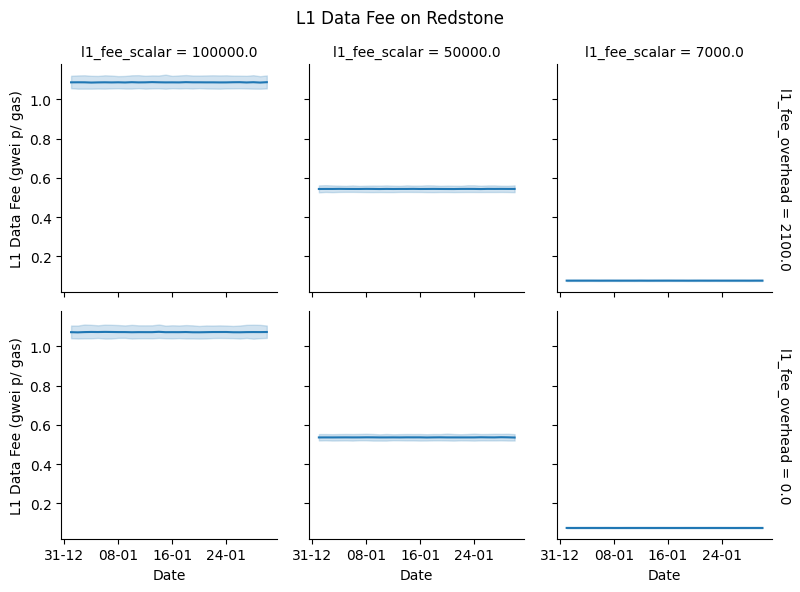

In [11]:
temp_df = sim_df.copy()
temp_df["l1_data_fee_cost"] = temp_df["revenue_data_eth"] / temp_df["l2_gas"]
temp_df["l1_data_fee_cost_gwei"] = temp_df["l1_data_fee_cost"]/0.000000001

g = sns.relplot(data=temp_df, x="timestamp", y="l1_data_fee_cost_gwei", col="l1_fee_scalar",
                row="l1_fee_overhead", kind="line", height=3, aspect=0.9, errorbar="pi",
                facet_kws={"margin_titles":True})
g.set(xlabel="Date", ylabel="L1 Data Fee (gwei p/ gas)")
for ax in g.axes[0]:
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=8))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.suptitle("L1 Data Fee on Redstone")
plt.tight_layout()
plt.show()

In [11]:
temp_df = sim_df.copy()
temp_df["l1_data_fee_cost"] = temp_df["revenue_data_eth"] / temp_df["l2_gas"]
temp_df["l1_data_fee_cost_gwei"] = temp_df["l1_data_fee_cost"]/0.000000001

temp_df.groupby(["l1_fee_overhead", "l1_fee_scalar"])["l1_data_fee_cost_gwei"].mean().round(2)

l1_fee_overhead  l1_fee_scalar
0.0              100000.0         1.07
                 50000.0          0.54
                 7000.0           0.08
2100.0           100000.0         1.09
                 50000.0          0.54
                 7000.0           0.08
Name: l1_data_fee_cost_gwei, dtype: float64

0.02205051608275001


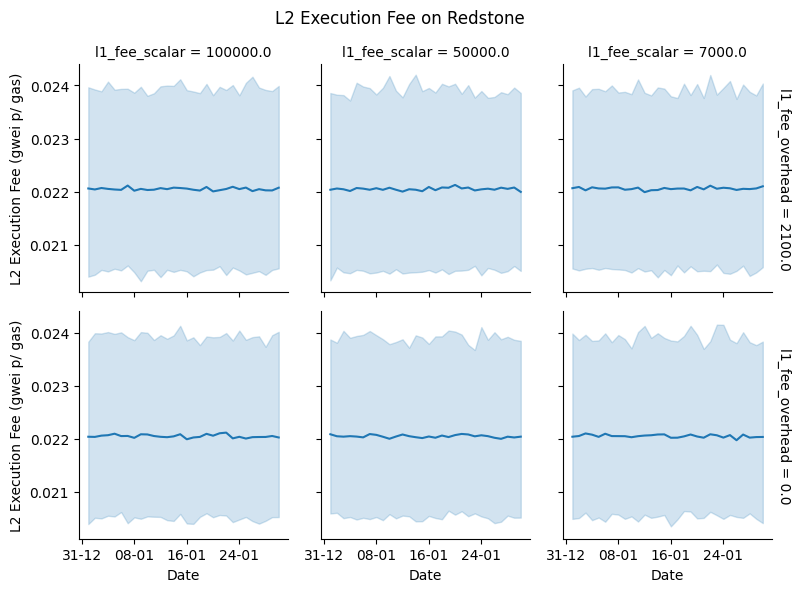

In [12]:
temp_df = sim_df.copy()
temp_df["exec_fee_cost"] = temp_df["revenue_exec_eth"] / temp_df["l2_gas"]
temp_df["exec_fee_cost_gwei"] = temp_df["exec_fee_cost"]/0.000000001
print(temp_df["exec_fee_cost_gwei"].mean())

g = sns.relplot(data=temp_df, x="timestamp", y="exec_fee_cost_gwei", col="l1_fee_scalar",
                row="l1_fee_overhead", kind="line", height=3, aspect=0.9, errorbar="pi",
                facet_kws={"margin_titles":True})
g.set(xlabel="Date", ylabel="L2 Execution Fee (gwei p/ gas)")
for ax in g.axes[0]:
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=8))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.suptitle("L2 Execution Fee on Redstone")
plt.tight_layout()
plt.show()